# Process Laptop Videos

Grab the text from the top corner.
Look for totally black screen.
Look for screen saver.
Look for login screen.

start at 40x56
wXh =78x18

ALL BLACK - off/screensaver
PURPLY - login
OTHERWISE - movie or something fullscreen


Using CPU. Note: This module is much faster with a GPU.


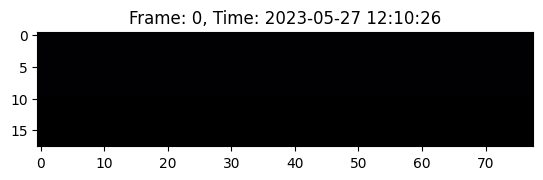

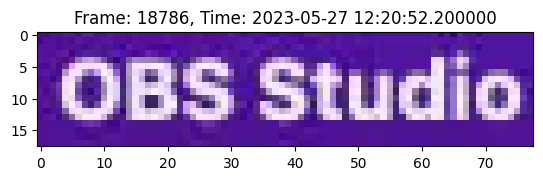

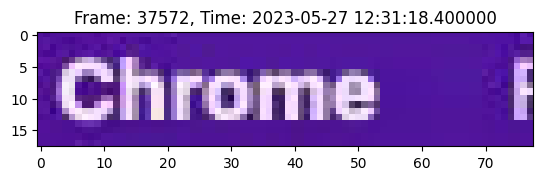

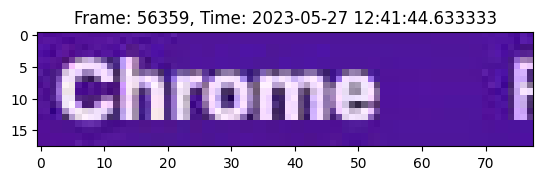

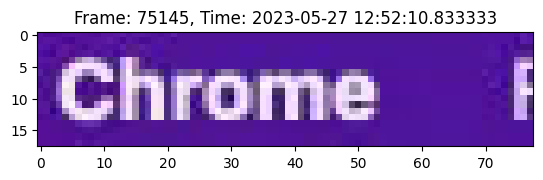

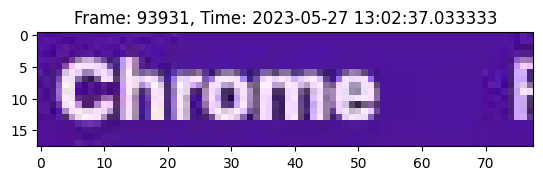

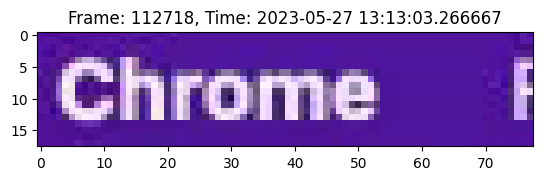

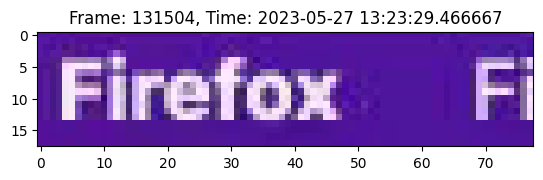

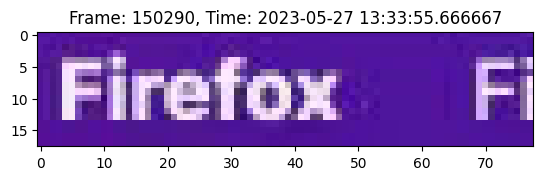

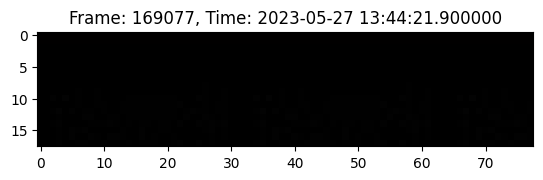

,Timestamp,Detection,Data
0,2023-05-27 12:10:26.000000,OFF,None
1,2023-05-27 12:20:52.200000,TEXT,obs studio
2,2023-05-27 12:31:18.400000,TEXT,chrome
3,2023-05-27 12:41:44.633333,TEXT,chrome
4,2023-05-27 12:52:10.833333,TEXT,chrome
5,2023-05-27 13:02:37.033333,TEXT,chrome
6,2023-05-27 13:13:03.266667,TEXT,chrome
7,2023-05-27 13:23:29.466667,TEXT,firefox
8,2023-05-27 13:33:55.666667,TEXT,firefox
9,2023-05-27 13:44:21.900000,OFF,None


'\ndef process_video(filename, N = 10):\n    cap = cv2.VideoCapture(filename)\n    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))\n    frames_to_read = np.linspace(0, total_frames - 1, N, dtype=int)\n    reader = easyocr.Reader([\'en\'], gpu=False)\n\n    data = {\n        "Timestamp": [],\n        "Detection": [],\n        "Data": []\n    }\n\n    for i in frames_to_read:\n        cap.set(cv2.CAP_PROP_POS_FRAMES, i)\n        ret, frame = cap.read()\n        if ret:\n            roi = frame[54:54+18,50:50+78]\n            result = reader.readtext(roi)\n            if len(result) > 0:\n                data["Timestamp"].append(i)\n                data["Detection"].append(\'TEXT\')\n                data["Data"].append(result[0][1].lower())  # assuming first detection is what we want\n            elif np.all(roi < [10, 10, 10]):\n                data["Timestamp"].append(i)\n                data["Detection"].append(\'OFF\')\n                data["Data"].append(None)\n            else

In [17]:
import cv2
import easyocr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import os
from datetime import datetime, timedelta

def process_video(filename, N = 10):
    cap = cv2.VideoCapture(filename)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_per_sec = cap.get(cv2.CAP_PROP_FPS)
    frames_to_read = np.linspace(0, total_frames - 1, N, dtype=int)
    reader = easyocr.Reader(['en'], gpu=False)
    
    # Extract datetime from filename
    date_str = filename.split('_')[0]
    time_str = filename.split('_')[1]
    start_datetime = datetime.strptime(date_str + time_str, '%m%d%y%H%M%S')
    
    data = {
        "Timestamp": [],
        "Detection": [],
        "Data": []
    }

    for i in frames_to_read:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            roi = frame[54:54+18,50:50+78]
            result = reader.readtext(roi)
            timestamp = start_datetime + timedelta(seconds=i/frames_per_sec)
            if len(result) > 0:
                data["Timestamp"].append(timestamp)
                data["Detection"].append('TEXT')
                data["Data"].append(result[0][1].lower())  # assuming first detection is what we want
            elif np.all(roi < [10, 10, 10]):
                data["Timestamp"].append(timestamp)
                data["Detection"].append('OFF')
                data["Data"].append(None)
            else:
                data["Timestamp"].append(timestamp)
                data["Detection"].append('OTHER')
                data["Data"].append(np.mean(roi, axis=(0, 1)).tolist())
            
            # Plot the frames with ROI
            plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            plt.title(f"Frame: {i}, Time: {timestamp}")
            plt.show()

    cap.release()
    df = pd.DataFrame(data)
    display(df)

filename = '052723_121026_laptop.mp4'
process_video(filename)

## Process All Videos and Save

this will *not* overwrite existing `video_meta.pkl` in the session folder.  If one exists and is incomplete, you must delete it or it will skip it.  Also skips over nonexistant participants/folders.

In [ ]:
import cv2
import easyocr
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
from multiprocessing import Pool
import pickle

def process_video(filename, N = 10):
    cap = cv2.VideoCapture(filename)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_per_sec = cap.get(cv2.CAP_PROP_FPS)
    reader = easyocr.Reader(['en'], gpu=False)
    
    # Extract datetime from filename
    date_str = filename.split('_')[0]
    time_str = filename.split('_')[1]
    start_datetime = datetime.strptime(date_str + time_str, '%m%d%y%H%M%S')
    
    data = {
        "Timestamp": [],
        "Detection": [],
        "Data": []
    }
    print(f'Starting {filename}')
    for i in range(0, total_frames, N):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            roi = frame[54:54+18,50:50+78]
            result = reader.readtext(roi)
            timestamp = start_datetime + timedelta(seconds=i/frames_per_sec)
            if len(result) > 0:
                data["Timestamp"].append(timestamp)
                data["Detection"].append('TEXT')
                data["Data"].append(result[0][1].lower())  # assuming first detection is what we want
            elif np.all(roi < [10, 10, 10]):
                data["Timestamp"].append(timestamp)
                data["Detection"].append('OFF')
                data["Data"].append(None)
            else:
                data["Timestamp"].append(timestamp)
                data["Detection"].append('OTHER')
                data["Data"].append(np.mean(roi, axis=(0, 1)).tolist())

    cap.release()
    df = pd.DataFrame(data)
    
    # Save DataFrame to pickle file
    pickle_name = os.path.splitext(os.path.basename(filename))[0] + '.pkl'
    pickle_path = os.path.join(os.path.dirname(filename) + '_processed', pickle_name)
    df.to_pickle(pickle_path)
    print(f'Done {filename}, saved to {pickle_path}')
    
def process_all_videos_in_folder(folder_path):
    # Create new processed folder
    processed_folder = folder_path + '_processed'
    os.makedirs(processed_folder, exist_ok=True)
    
    # Get list of all video files in folder
    video_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.mp4')]
    
    # Process video files in parallel
    with Pool(4) as p:
        p.map(process_video, video_files)

folder_path = '/Volumes/Tertiary/OBS_Recordings/laptop_handbrake'
process_all_videos_in_folder(folder_path)


## Read DF Back

In [6]:
FOLDER = '/Volumes/Tertiary/OBS_Recordings/laptop_handbrake_processed'
filename = '052723_121026_laptop'
df = pd.read_pickle(FOLDER + filename + '.pkl')
df.head(50)

,timestamp,status,ocr_string
0,1682190516410.0,PAUSED,resume |
1,1682191415565.0,PAUSED,resume | 1
2,1682191415698.333252,PAUSED,resume | l
3,1682191415831.666748,PAUSED,resume |
4,1682191415965.0,UNKNOWN,4ong 43 ou cam |
5,1682191416098.333252,UNKNOWN,as you can: |
6,1682191416231.666748,UNKNOWN,2 | 00
7,1682191416366.666748,UNKNOWN,ony 4> 9ou cam |
8,1682191416500.0,PAUSED,resume |
9,1682191417833.333252,PLAYING,|
